Preview data:


,SDNN,rMSSD,pNN50,Class
0,54,19,1,1
1,158,36,15,1
2,129,24,4,1
3,62,13,0,1
4,101,18,1,1


Shape: (37, 3) Label unique: [0 1]
Fitting 37 folds for each of 20 candidates, totalling 740 fits
Best params: {'svc__C': 0.1, 'svc__gamma': 0.001}
Mean LOOCV accuracy: 0.8648648648648649
Classification report (LOOCV):
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        18
           1       1.00      0.74      0.85        19

    accuracy                           0.86        37
   macro avg       0.89      0.87      0.86        37
weighted avg       0.89      0.86      0.86        37

Confusion matrix:
 [[18  0]
 [ 5 14]]


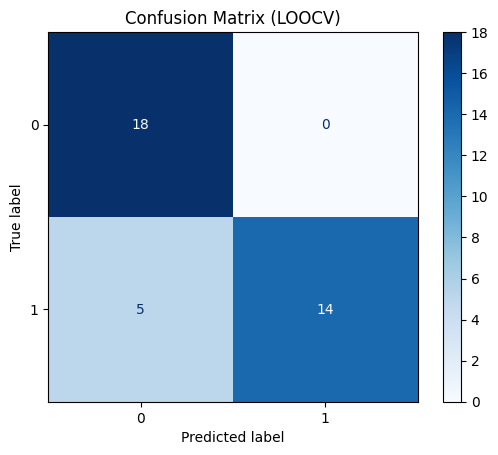

ROC AUC: 0.0


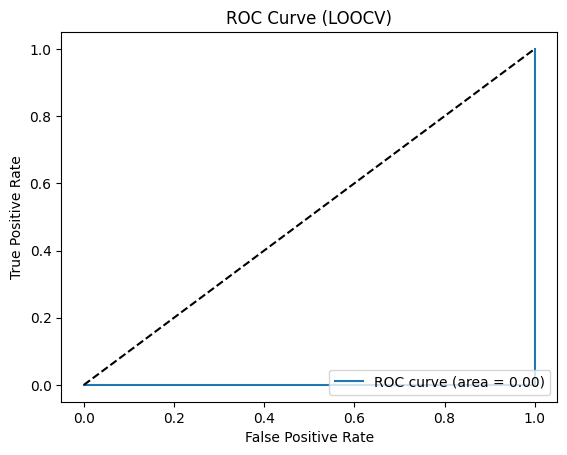

Hasil prediksi & laporan disimpan di folder results/
Model final disimpan di models/svm_rbf_hrv_loocv.joblib


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay
)
import joblib

RANDOM_STATE = 42

# Load dataset
df = pd.read_csv("Data/time-domain-cancer.csv")
df.columns = [c.strip() for c in df.columns]

# Ambil fitur & label
X = df[['SDNN', 'rMSSD', 'pNN50']].values
y = df['Class'].values

print("Preview data:")
display(df.head())
print("Shape:", X.shape, "Label unique:", np.unique(y))

# Pipeline SVM dengan scaling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', class_weight='balanced',
                probability=True, random_state=RANDOM_STATE))
])

# Hyperparameter grid
param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [1e-3, 1e-2, 0.1, 1, 'scale']
}

loo = LeaveOneOut()

# GridSearchCV pakai LOOCV
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=loo,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid.fit(X, y)

print("Best params:", grid.best_params_)
print("Mean LOOCV accuracy:", grid.best_score_)

best_model = grid.best_estimator_

y_true_all = []
y_pred_all = []
y_prob_all = []

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    y_true_all.append(y_test[0])
    y_pred_all.append(y_pred[0])
    if hasattr(best_model, "predict_proba"):
        y_prob_all.append(best_model.predict_proba(X_test)[0][1])

y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)
y_prob_all = np.array(y_prob_all)

print("Classification report (LOOCV):")
print(classification_report(y_true_all, y_pred_all))
cm = confusion_matrix(y_true_all, y_pred_all)
print("Confusion matrix:\n", cm)

# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (LOOCV)")
plt.show()

# ROC Curve
try:
    auc = roc_auc_score(y_true_all, y_prob_all)
    print("ROC AUC:", auc)
    fpr, tpr, _ = roc_curve(y_true_all, y_prob_all)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (area = {auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (LOOCV)")
    plt.legend(loc="lower right")
    plt.show()
except Exception as e:
    print("ROC AUC gagal dihitung:", e)

# Buat folder hasil
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

# Simpan prediksi
out_df = pd.DataFrame({
    "true": y_true_all,
    "pred": y_pred_all,
    "prob": y_prob_all
})
out_df.to_csv("results/loocv_predictions.csv", index=False)

pd.DataFrame(classification_report(y_true_all, y_pred_all, output_dict=True)).transpose() \
    .to_csv("results/loocv_classification_report.csv")

print("Hasil prediksi & laporan disimpan di folder results/")

# Simpan model final
best_model.fit(X, y)
joblib.dump(best_model, "models/svm_rbf_hrv_loocv.joblib")
print("Model final disimpan di models/svm_rbf_hrv_loocv.joblib")
